In [2]:
import os
import itertools
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
import pingouin as pg


from endoanalysis.agreement import OKSimilarity, compute_kappas
from endoanalysis.datasets import PointsDataset

In [3]:
similarity = OKSimilarity(scale=7.36)

In [4]:
agreement_dir = "../data/Dataset/files_lists/Agreement/Hidden/Complete/"
raters = ['Ptg3', 'Stud1', 'Stud2', 'Stud3']
# raters = [ 'Stud1', 'Ptg3', 'Ptg3']

datasets = {}
dataloaders = {}
datasets_lens = {}
keypoints  = {}
datasets = {}

for expert_name in raters:
    images_file_list = os.path.join(agreement_dir, expert_name, "images.txt")
    labels_file_list = os.path.join(agreement_dir, expert_name, "labels.txt")
    dataset = PointsDataset(
        images_file_list,
        labels_file_list,
        keypoints_dtype = float
    )
    datasets_lens[expert_name] = len(dataset)
    datasets[expert_name] = dataset
    
    keypoints[expert_name] = dataset.collate()["keypoints"]

    

In [5]:
len(datasets['Ptg3'])

20

In [150]:
[x for x in datasets['Ptg3'].images_paths]

['../data/Dataset/images/Agreement/Hidden/Complete/Ptg3/1857.png',
 '../data/Dataset/images/Agreement/Hidden/Complete/Ptg3/1940.png',
 '../data/Dataset/images/Agreement/Hidden/Complete/Ptg3/1980.png',
 '../data/Dataset/images/Agreement/Hidden/Complete/Ptg3/2170.png',
 '../data/Dataset/images/Agreement/Hidden/Complete/Ptg3/2417.png',
 '../data/Dataset/images/Agreement/Hidden/Complete/Ptg3/2535.png',
 '../data/Dataset/images/Agreement/Hidden/Complete/Ptg3/2614.png',
 '../data/Dataset/images/Agreement/Hidden/Complete/Ptg3/2631.png',
 '../data/Dataset/images/Agreement/Hidden/Complete/Ptg3/2651.png',
 '../data/Dataset/images/Agreement/Hidden/Complete/Ptg3/2669.png',
 '../data/Dataset/images/Agreement/Hidden/Complete/Ptg3/2709.png',
 '../data/Dataset/images/Agreement/Hidden/Complete/Ptg3/2716.png',
 '../data/Dataset/images/Agreement/Hidden/Complete/Ptg3/3614.png',
 '../data/Dataset/images/Agreement/Hidden/Complete/Ptg3/3749.png',
 '../data/Dataset/images/Agreement/Hidden/Complete/Ptg3/3906.p

In [139]:
datasets_lens_list = list(datasets_lens.values())
if len(np.unique(datasets_lens_list)) != 1:
    raise Exception("Some annotators have different numbe of images than the others")
else:
    num_images = datasets_lens_list[0]

In [140]:
kappas = compute_kappas(
    keypoints,
    similarity,
    raters,
    range(num_images),
    missings_as_classes=True
)

In [141]:
kappas

[0.706286930539687,
 0.7619024056574122,
 0.7679515420116279,
 0.7036309280644146,
 0.6228629987565455,
 0.7425017882653783]

In [142]:
np.mean(kappas)

0.7175227655491776

In [137]:
raters

['Ptg3', 'Stud1', 'Stud2', 'Stud3', 'Stud4']

In [10]:
num_images = 10
raters = ['Ptg3', 'Stud1', 'Stud2', 'Stud3']
keypoints_nums = np.zeros((len(raters), num_images))

for expert_i, expert in enumerate(raters):
    keypoints_num_expert = [len(keypoints[expert].from_image(image_i)) for image_i in range(num_images)]
    keypoints_nums[expert_i] = np.array(keypoints_num_expert)

In [11]:
df = pd.DataFrame()

In [12]:
np.arange(num_images).repeat(2)

array([0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9])

In [13]:
keypoints_nums

array([[122., 105., 161., 205., 180., 245., 131., 130., 165., 199.],
       [125., 102., 145., 182., 170., 223., 127., 124., 170., 156.],
       [111.,  95., 154., 182., 182., 261., 142., 154., 173., 179.],
       [134., 104., 157., 203., 183., 270., 141., 150., 198., 189.]])

In [14]:
keypoints_nums

array([[122., 105., 161., 205., 180., 245., 131., 130., 165., 199.],
       [125., 102., 145., 182., 170., 223., 127., 124., 170., 156.],
       [111.,  95., 154., 182., 182., 261., 142., 154., 173., 179.],
       [134., 104., 157., 203., 183., 270., 141., 150., 198., 189.]])

In [15]:
blocks = []
for expert_i, row in enumerate(keypoints_nums):
    blocks. append(np.hstack([row, np.ones(num_images) * expert_i, np.arange(num_images)]))
    
blocks = np.hstack(blocks)

df_dict = {
    "rater": np.arange(len(raters)).repeat(num_images),
    "image":  np.hstack([np.arange(num_images)]* len(raters)),
    "nums": keypoints_nums.flatten(order="C")
}

df = pd.DataFrame(df_dict)

In [16]:
df_dict

{'rater': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]),
 'image': array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1,
        2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 'nums': array([122., 105., 161., 205., 180., 245., 131., 130., 165., 199., 125.,
        102., 145., 182., 170., 223., 127., 124., 170., 156., 111.,  95.,
        154., 182., 182., 261., 142., 154., 173., 179., 134., 104., 157.,
        203., 183., 270., 141., 150., 198., 189.])}

In [17]:
icc = pg.intraclass_corr(data=df, targets='image', raters='rater',ratings='nums').round(3)

In [18]:
icc

,Type,Description,ICC,F,df1,df2,pval,CI95%
0,ICC1,Single raters absolute,0.915,44.137,9,30,0.0,"[0.8, 0.98]"
1,ICC2,Single random raters,0.916,70.915,9,27,0.0,"[0.76, 0.98]"
2,ICC3,Single fixed raters,0.946,70.915,9,27,0.0,"[0.87, 0.98]"
3,ICC1k,Average raters absolute,0.977,44.137,9,30,0.0,"[0.94, 0.99]"
4,ICC2k,Average random raters,0.978,70.915,9,27,0.0,"[0.93, 0.99]"
5,ICC3k,Average fixed raters,0.986,70.915,9,27,0.0,"[0.96, 1.0]"


In [19]:


data = pg.read_dataset('icc')

icc = pg.intraclass_corr(data=data, targets='Wine', raters='Judge',

                         ratings='Scores').round(3)

icc.set_index("Type")

,Description,ICC,F,df1,df2,pval,CI95%
Type,,,,,,,
ICC1,Single raters absolute,0.728,11.680,7,24,0.0,"[0.43, 0.93]"
ICC2,Single random raters,0.728,11.787,7,21,0.0,"[0.43, 0.93]"
ICC3,Single fixed raters,0.729,11.787,7,21,0.0,"[0.43, 0.93]"
ICC1k,Average raters absolute,0.914,11.680,7,24,0.0,"[0.75, 0.98]"
ICC2k,Average random raters,0.914,11.787,7,21,0.0,"[0.75, 0.98]"
ICC3k,Average fixed raters,0.915,11.787,7,21,0.0,"[0.75, 0.98]"


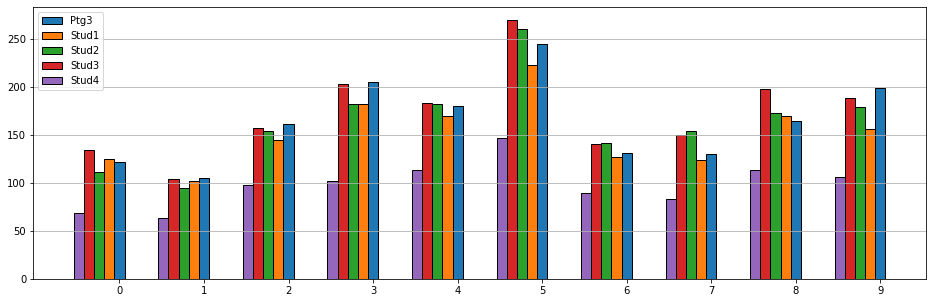

In [20]:
experts = ['Ptg3', 'Stud1', 'Stud2', 'Stud3', 'Stud4']


fig, ax = plt.subplots(1, figsize=(16,5))

keypoints_nums = np.zeros((len(experts), num_images))

for expert_i, expert in enumerate(experts):
    keypoints_num_expert = [len(keypoints[expert].from_image(image_i)) for image_i in range(num_images)]
    keypoints_nums[expert_i] = np.array(keypoints_num_expert)

x = np.arange(10)
for idx in range(len(experts)):
    ax.set_xticks(np.arange(10))
    ax.bar(x - idx*0.12 , keypoints_nums[idx], width=0.12 , align='center', edgecolor='black', zorder=1)
    ax.legend(experts)
    ax.grid(b=True,axis="y", zorder=2)

In [76]:
import itertools
import copy
import numpy as np
from tqdm import tqdm
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import cohen_kappa_score

def get_batch_relaibility_matrix(
    targets_from_batch1, 
    targets_from_batch2, 
    similarity,
    indexes_to_consider,
    missings_as_classes = False
):
    '''
    Composes relaibility matrix for two batches.
    
    Parameters
    ----------
    targets_from_batch1 : endoanalysis.targets.TargetsBatchArray like
        batch of targets corresponding to a set of images from the first rater in pair. 
        Must have have the method targets_from_batch1.from_image(), 
        returning the container of targets corrsponding to a given image.
        The container must be compatible with similarity.
    targets_from_batch2 :  endoanalysis.targets.TargetsBatchArray  like
        the same as targets_from_batch1, but for the second rater.
    similarity : endoanalysis.agreement.SimilarityMeasure
        similarity measure, must be compatible with targets_from_batch1 and targets_from_batch2
    indexes_to_consider : iterable
        an iterable of image indexes which sould be taken into concideration. 
        All indexes must be present in both  targets_from_batch1 an targets_from_batch2
    missings_as_classes : bool
        wheather to consider not matched targeds as separate class (with -1 label)
        
    Returns
    -------
    relaibility_matrix : ndarray
        relaibility matrix. The shape is (2, num_matched), where num_matched
        is the number of targets which were sucsefully matched. This number
        could not be gereater than the maximum total number of targets in
        batch1 or batch2
    '''
    
    rel_matrices = []
    for image_i in indexes_to_consider:
        targets1 = targets_from_batch1.from_image(image_i)
        targets2 = targets_from_batch2.from_image(image_i)

        sim_matrix = similarity.matrix(targets1, targets2)

        row_ids, col_ids = linear_sum_assignment(sim_matrix, maximize=True)
        
        
        rel_matrices.append(np.vstack([targets1.classes()[row_ids], targets2.classes()[col_ids]]))
        
        missings1 = np.setdiff1d(np.arange(len(targets1)), row_ids) 
        missings2 = np.setdiff1d(np.arange(len(targets2)), col_ids) 


        
        rel_matrices.append(np.vstack([targets1.classes()[missings1], np.ones(len(missings1)) * -1]))
        rel_matrices.append(np.vstack([np.ones(len(missings2)) * -1, targets2.classes()[missings2] ]))
    relaibility_matrix = np.hstack(rel_matrices)
    
    return relaibility_matrix


In [81]:
get_batch_relaibility_matrix(keypoints["Stud1"], keypoints["Stud2"], similarity, indexes_to_consider=[4] )

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1., -1., -1., -1., -1., -1., -1., -1., -1.